## Significant saliva exosome genes를 이용한 예후 cluster 예측 모델

In [1]:
import pandas as pd

ML_data = pd.read_csv("/Users/lywoo/Desktop/winter/ML_data.csv", index_col="Unnamed: 0")
ML_data.describe()

,S100A9,KRT16,SBSN,KRT6A,SLPI,AQP5,ALB,LRRC26,MUC5AC
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,12.416309,7.551251,5.454267,8.368113,12.883760,9.472532,5.912782,5.056020,8.563896
std,2.073048,2.187381,1.396074,3.136737,2.137702,2.935085,2.103262,0.969235,3.711819
min,6.760723,4.163354,4.163354,4.163354,5.600158,4.503868,4.163354,4.163354,4.163354
25%,10.979699,5.780481,4.599483,5.746193,11.572313,6.930487,4.848201,4.520825,5.607724
50%,12.131915,7.346604,4.993393,7.751672,13.114566,9.068262,5.294565,4.800358,7.510937
75%,13.769173,8.798053,5.759644,10.378846,14.100156,11.865758,5.974542,5.273086,10.556528
max,19.911829,15.762874,11.786527,18.285403,20.469997,16.277530,21.198309,10.524299,19.989514


In [19]:
from sklearn.model_selection import train_test_split

X = ML_data.iloc[:, :-1]
y = ML_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print("X_train:", len(X_train))
print("y_train:", len(y_train))
print("X_test:", len(X_test))
print("y_test:", len(y_test))

X_train: 267
y_train: 267
X_test: 67
y_test: 67


In [24]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto", random_state=42)
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 200, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=42
        )
    
    score = cross_val_score(classifier_obj, X, y, cv=4, n_jobs=-1)
    accuracy = score.mean()
    
    return accuracy

In [27]:
study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100, show_progress_bar=True)
print(study.best_trial.params)

Best trial: 63. Best value: 0.832473: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]

{'classifier': 'RandomForest', 'rf_max_depth': 5, 'rf_n_estimators': 38}


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(
    n_estimators=38,
    max_depth=5,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)
prediction = model.predict(X_test)
report = classification_report(y_test, prediction)
predict_score = accuracy_score(y_test, prediction)
print(report, "\n")
print("Accuracy Score:", predict_score)

              precision    recall  f1-score   support

         1&3       0.91      0.91      0.91        44
           2       0.83      0.83      0.83        23

    accuracy                           0.88        67
   macro avg       0.87      0.87      0.87        67
weighted avg       0.88      0.88      0.88        67
 

Accuracy Score: 0.8805970149253731


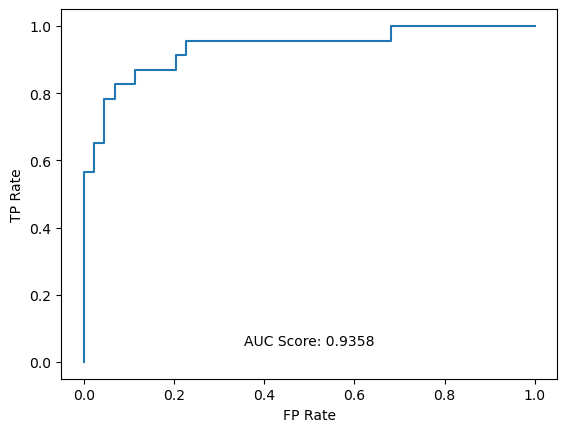

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label="2")
auc_score = round(roc_auc_score(y_test, y_pred_proba), 4)


plt.plot(fpr, tpr)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.text(.5, .05, f"AUC Score: {auc_score}", ha="center")
plt.show()

Feature names: ['S100A9' 'KRT16' 'SBSN' 'KRT6A' 'SLPI' 'AQP5' 'ALB' 'LRRC26' 'MUC5AC']
Feature importances: [0.09203909 0.16644049 0.28015647 0.08539181 0.10122219 0.09702373
 0.04423701 0.06312139 0.07036782] 

SBSN 0.2801564687761736
KRT16 0.16644049111316955
SLPI 0.10122218612908268
AQP5 0.09702373054845533
S100A9 0.0920390915998352
KRT6A 0.08539180751644747
MUC5AC 0.07036782260738474
LRRC26 0.06312138820680861
ALB 0.04423701350264277


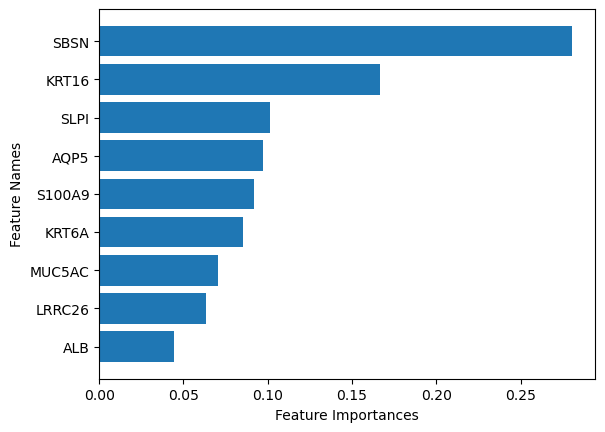

In [79]:
import matplotlib.pyplot as plt

print("Feature names:", model.feature_names_in_)
print("Feature importances:", model.feature_importances_, "\n")
feature_dic = dict(zip(model.feature_names_in_, model.feature_importances_))

sorted_features = sorted(feature_dic.items(), key=lambda x: x[1], reverse=True)
names= []
importances = []
for name, importance in sorted_features:
    names.append(name)
    importances.append(importance)
    print(name, importance)
    
plt.barh(names, importances)
plt.xlabel("Feature Importances")
plt.ylabel("Feature Names")
plt.gca().invert_yaxis()
plt.show()

In [96]:
pd.set_option("display.max_rows", None)
pd.DataFrame({"y_test":y_test, "prediction":prediction})

,y_test,prediction
TCGA-50-8459-01A-11R-2326-07,1&3,1&3
TCGA-55-6970-01A-11R-1949-07,1&3,1&3
TCGA-55-6980-01A-11R-1949-07,2,2
TCGA-55-A4DG-01A-11R-A24H-07,1&3,1&3
TCGA-69-7978-01A-11R-2187-07,2,2
TCGA-55-A493-01A-11R-A24H-07,2,2
TCGA-49-6767-01A-11R-1858-07,2,2
TCGA-67-3774-01A-01R-0946-07,1&3,1&3
TCGA-44-3918-01B-02R-A277-07,1&3,1&3
TCGA-86-A4P7-01A-11R-A24X-07,1&3,1&3


## Cluster1&3 : Cluster2 = 1 : 1, 임상데이터 x

In [99]:
import pandas as pd

pd.set_option("display.max_rows", 10)


new_ML_data = pd.read_csv("/Users/lywoo/Desktop/winter/new_ML_data.csv", index_col="Unnamed: 0")
new_ML_data.describe()

,S100A9,KRT16,SBSN,KRT6A,SLPI,AQP5,ALB,LRRC26,MUC5AC
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,12.599713,7.932031,5.757245,8.728996,12.382717,9.003909,5.955463,5.051644,8.387603
std,2.192786,2.301982,1.505517,3.327197,1.951261,2.993792,2.140060,1.031618,3.698301
min,7.273218,4.163354,4.163354,4.163354,5.600158,4.503868,4.163354,4.163354,4.163354
25%,11.160803,6.033240,4.834916,5.995129,11.207539,6.200443,4.810350,4.476436,5.386051
50%,12.303824,7.718165,5.267123,8.000321,12.558646,8.692139,5.318228,4.785782,7.093631
75%,14.002704,9.511946,6.183252,10.777355,13.735153,11.459762,6.005873,5.250715,10.554300
max,19.911829,15.762874,11.786527,18.285403,16.842360,16.277530,21.198309,10.524299,19.989514


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X2 = new_ML_data.iloc[:, :-1]
y2 = new_ML_data.iloc[:, -1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, shuffle=True, random_state=42)

In [114]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto", random_state=42)
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 200, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=42
        )
    
    score = cross_val_score(classifier_obj, X_train2, y_train2, cv=cv, n_jobs=1)
    accuracy = score.mean()
    
    return accuracy

In [115]:
study2 = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study2.optimize(objective, n_trials=100, show_progress_bar=True)
print(study2.best_trial.params)

Best trial: 30. Best value: 0.831551: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

{'classifier': 'RandomForest', 'rf_max_depth': 10, 'rf_n_estimators': 141}


In [116]:
from sklearn.metrics import classification_report, accuracy_score

model2 = RandomForestClassifier(
    n_estimators=141,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

model2.fit(X_train2, y_train2)
prediction2 = model2.predict(X_test2)
report2 = classification_report(y_test2, prediction2)
predict_score2 = accuracy_score(y_test2, prediction2)
print(report2, "\n")
print("Accuracy Score:", predict_score2)

              precision    recall  f1-score   support

         1&3       0.70      0.90      0.79        21
           2       0.87      0.62      0.72        21

    accuracy                           0.76        42
   macro avg       0.79      0.76      0.76        42
weighted avg       0.79      0.76      0.76        42
 

Accuracy Score: 0.7619047619047619


0.3748733535967579


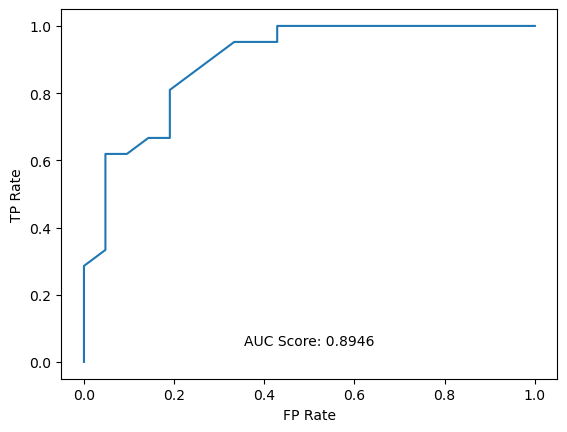

In [120]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]
fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred_proba2, pos_label="2")
auc_score2 = round(roc_auc_score(y_test2, y_pred_proba2), 4)

#임계값
youden = tpr2 - fpr2
best_idx = np.argmax(youden)
best_threshold = thresholds2[best_idx]
print(best_threshold)


plt.plot(fpr2, tpr2)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.text(.5, .05, f"AUC Score: {auc_score2}", ha="center")
plt.show()

Feature names: ['S100A9' 'KRT16' 'SBSN' 'KRT6A' 'SLPI' 'AQP5' 'ALB' 'LRRC26' 'MUC5AC']
Feature importances: [0.1242871  0.11480818 0.22132931 0.11794128 0.09833416 0.11535784
 0.06159982 0.05559358 0.09074873] 

SBSN 0.22132931342038667
S100A9 0.1242870997475349
KRT6A 0.11794128279354538
AQP5 0.11535783620240331
KRT16 0.11480817997919064
SLPI 0.09833415997251131
MUC5AC 0.0907487290674135
ALB 0.061599815788205906
LRRC26 0.05559358302880839


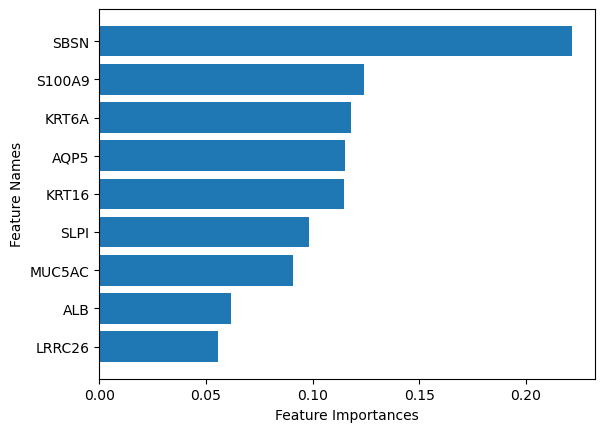

In [119]:
import matplotlib.pyplot as plt

print("Feature names:", model2.feature_names_in_)
print("Feature importances:", model2.feature_importances_, "\n")
feature_dic2 = dict(zip(model2.feature_names_in_, model2.feature_importances_))

sorted_features2 = sorted(feature_dic2.items(), key=lambda x: x[1], reverse=True)
names2= []
importances2 = []
for name, importance in sorted_features2:
    names2.append(name)
    importances2.append(importance)
    print(name, importance)
    
plt.barh(names2, importances2)
plt.xlabel("Feature Importances")
plt.ylabel("Feature Names")
plt.gca().invert_yaxis()
plt.show()

### 임계값 조정(best_threshold=0.3748733535967579)

In [122]:
threshold_prediction = (y_pred_proba2>=best_threshold).astype(int)
threshold_labels = np.where(threshold_prediction==1, "2", "1&3")

threshold_report = classification_report(y_test2, threshold_labels)
threshold_predict_score = accuracy_score(y_test2, threshold_labels)
print(threshold_report, "\n")
print("Accuracy Score:", threshold_predict_score)

              precision    recall  f1-score   support

         1&3       0.81      0.81      0.81        21
           2       0.81      0.81      0.81        21

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42
 

Accuracy Score: 0.8095238095238095


In [127]:
from sklearn.model_selection import cross_val_predict

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
predict_proba = cross_val_predict(model2, X2, y2, cv=cv, method="predict_proba")[:, 1]
predict_label = (predict_proba>=0.3748733535967579).astype(int)


cox_data = pd.read_csv("/Users/lywoo/Desktop/winter/cox_data.csv", index_col="Unnamed: 0")

cox_data["Predict cluster"] = np.where(predict_label==1, "2", "1&3")
cox_data.to_csv("cox_data.csv")



## Feature 추가 Ver.

In [181]:
import pandas as pd

new_ML_data_plus = pd.read_csv("/Users/lywoo/Desktop/winter/new_ML_data_plus.csv", index_col="Unnamed: 0")
new_ML_data_plus = new_ML_data_plus[['S100A9', 'KRT16', 'SBSN', 'KRT6A', 'SLPI', 'AQP5', 'ALB', 'LRRC26', 'MUC5AC', 'age', 'gender', 'race', 'stage', 'tobacco_status', 'cluster']]

In [182]:
new_ML_data_plus['tobacco_status'].unique()

array(['Lifelong Non-Smoker', 'Current Reformed Smoker for < or = 15 yrs',
       'Current Smoker', 'Current Reformed Smoker for > 15 yrs',
       'Current Reformed Smoker, Duration Not Specified', 'Not Reported'],
      dtype=object)

In [188]:
X3 = new_ML_data_plus.iloc[:, :-1]
y3 = new_ML_data_plus.iloc[:, -1]

#race encoding
X3['race'] = X3['race'].replace('not reported', 'Unknown')

race_mapping = {
    "Unknown" : 0,
    "white" : 1,
    "black or african american" : 2,
    "asian" : 3,
    "american indian or alaska native" : 4
}
X3['race'] = X3['race'].map(race_mapping)

#gender encoding
X3 = pd.get_dummies(X3, columns=['gender'], drop_first=True)
bool_cols = X3.select_dtypes(include='bool').columns
X3[bool_cols] = X3[bool_cols].astype(int)

#stage encoding
stage_mapping = {
    "Unknown" : 0,
    "Stage I" : 1,
    "Stage IA" : 1,
    "Stage IB" : 1,
    "Stage IIA" : 2,
    "Stage IIB" : 2,
    "Stage IIIA" : 3,
    "Stage IIIB" : 3,
    "Stage IV" : 4
}
X3['stage'] = X3['stage'].map(stage_mapping)

#tobacco_status encoding
tobacco_mapping = {
    "Not Reported" : 0,
    "Lifelong Non-Smoker" : 1,
    "Current Reformed Smoker for > 15 yrs" : 2,
    "Current Reformed Smoker for < or = 15 yrs" : 3, 
    "Current Reformed Smoker, Duration Not Specified" : 4,
    "Current Smoker" : 5
}
X3['tobacco_status'] = X3['tobacco_status'].map(tobacco_mapping)

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, stratify=y3, shuffle=True, random_state=42)

print("X_train3:", len(X_train3))
print("X_test3:", len(X_test3))
print("y_train3:", len(y_train3))
print("y_test3:", len(y_test3))

X_train3: 164
X_test3: 41
y_train3: 164
y_test3: 41


In [191]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto", random_state=42)
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 200, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=42
        )
    
    score = cross_val_score(classifier_obj, X_train3, y_train3, cv=cv, n_jobs=1)
    accuracy = score.mean()
    
    return accuracy

In [192]:
study3 = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study3.optimize(objective, n_trials=100, show_progress_bar=True)
print(study3.best_trial.params)

Best trial: 64. Best value: 0.817235: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]

{'classifier': 'RandomForest', 'rf_max_depth': 8, 'rf_n_estimators': 122}


In [193]:
from sklearn.metrics import classification_report, accuracy_score

model3 = RandomForestClassifier(
    n_estimators=122,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

model3.fit(X_train3, y_train3)
prediction3 = model3.predict(X_test3)
report3 = classification_report(y_test3, prediction3)
predict_score3 = accuracy_score(y_test3, prediction3)
print(report3, "\n")
print("Accuracy Score:", predict_score3)

              precision    recall  f1-score   support

         1&3       0.69      0.90      0.78        20
           2       0.87      0.62      0.72        21

    accuracy                           0.76        41
   macro avg       0.78      0.76      0.75        41
weighted avg       0.78      0.76      0.75        41
 

Accuracy Score: 0.7560975609756098


0.37952581540105107


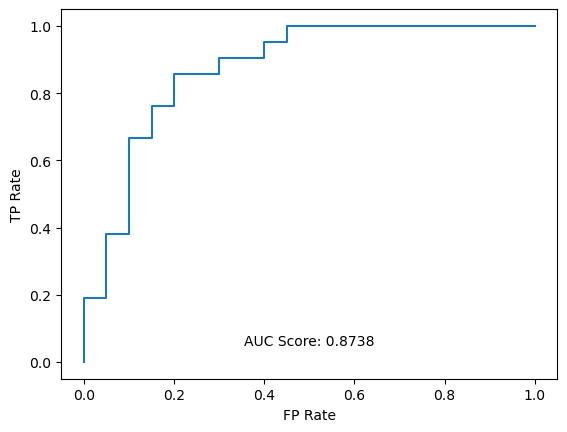

In [194]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_pred_proba3 = model3.predict_proba(X_test3)[:, 1]
fpr3, tpr3, thresholds3 = roc_curve(y_test3, y_pred_proba3, pos_label="2")
auc_score3 = round(roc_auc_score(y_test3, y_pred_proba3), 4)

youden2 = tpr3 - fpr3
best_idx2 = np.argmax(youden2)
best_threshold2 = thresholds3[best_idx2]
print(best_threshold2)

plt.plot(fpr3, tpr3)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.text(.5, .05, f"AUC Score: {auc_score3}", ha="center")
plt.show()

Feature names: ['S100A9' 'KRT16' 'SBSN' 'KRT6A' 'SLPI' 'AQP5' 'ALB' 'LRRC26' 'MUC5AC'
 'age' 'race' 'stage' 'tobacco_status' 'gender_male']
Feature importances: [0.12701152 0.12146216 0.17609292 0.11040053 0.06627016 0.11576428
 0.05243863 0.06755067 0.06664253 0.04282918 0.01060197 0.02119681
 0.0146612  0.00707744] 

SBSN 0.17609292046752598
S100A9 0.1270115217214293
KRT16 0.12146216147254744
AQP5 0.1157642768047626
KRT6A 0.11040053442786994
LRRC26 0.06755066608807353
MUC5AC 0.06664253013190538
SLPI 0.06627015795884927
ALB 0.05243862674366148
age 0.04282918495941288
stage 0.02119680598494356
tobacco_status 0.014661200917981744
race 0.010601971830012975
gender_male 0.007077440491023969


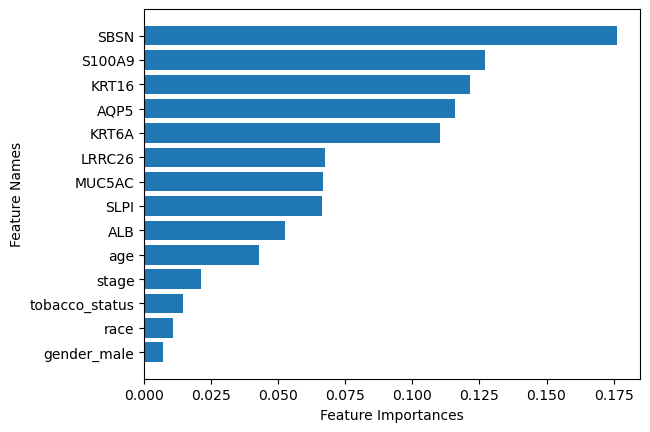

In [195]:
import matplotlib.pyplot as plt

print("Feature names:", model3.feature_names_in_)
print("Feature importances:", model3.feature_importances_, "\n")
feature_dic3 = dict(zip(model3.feature_names_in_, model3.feature_importances_))

sorted_features3 = sorted(feature_dic3.items(), key=lambda x: x[1], reverse=True)
names3= []
importances3 = []
for name, importance in sorted_features3:
    names3.append(name)
    importances3.append(importance)
    print(name, importance)
    
plt.barh(names3, importances3)
plt.xlabel("Feature Importances")
plt.ylabel("Feature Names")
plt.gca().invert_yaxis()
plt.show()

In [196]:
threshold_prediction2 = (y_pred_proba3 >= best_threshold2).astype(int)
threshold_labels2 = np.where(threshold_prediction2==1, "2", "1&3")

threshold_report2 = classification_report(y_test3, threshold_labels2)
threshold_predict_score2 = accuracy_score(y_test3, threshold_labels2)
print(threshold_report2, "\n")
print("Accuracy Score:", threshold_predict_score2)

              precision    recall  f1-score   support

         1&3       0.84      0.80      0.82        20
           2       0.82      0.86      0.84        21

    accuracy                           0.83        41
   macro avg       0.83      0.83      0.83        41
weighted avg       0.83      0.83      0.83        41
 

Accuracy Score: 0.8292682926829268
